# ABOUT THE MODEL

In [62]:
'''
NAME          : model_1 
DATASET       : MNIST
MODEL         : Two layered CNN with Max-pooling and Valid-padding
ACCURACY      : 90.40 %
DATASET CLASS : custom
'''
# Model Name
model_name = 'model_1'

# PRELIMINARY 

In [2]:
'''IMPORTING MODULES'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

import os
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()

# LOADING THE DATASET

In [3]:
'''CREATING DATASET CLASS'''

import codecs
from PIL import Image
training_file = 'training.pt'
test_file = 'test.pt'

class fashion_dataset(Dataset):
    
    training_file = 'training.pt'
    test_file = 'test.pt'
        
    def __init__(self, path, train=True, transform=None):

        self.path = path
        self.train = train
        self.transform = transform

        if self.train:
            training_set = (
                read_image_file(os.path.join(self.path, 'train-images-idx3-ubyte')),
                read_label_file(os.path.join(self.path, 'train-labels-idx1-ubyte'))
            )
            
            with open(os.path.join(path, training_file), 'wb') as f:
                torch.save(training_set, f)
            
            self.train_data, self.train_labels = torch.load(
                os.path.join(self.path, self.training_file))

        else:
            test_set = (
                read_image_file(os.path.join(self.path, 't10k-images-idx3-ubyte')),
                read_label_file(os.path.join(self.path, 't10k-labels-idx1-ubyte'))
            )
            
            with open(os.path.join(path, test_file), 'wb') as f:
                torch.save(test_set, f)
            
            self.test_data, self.test_labels = torch.load(
                os.path.join(self.path, self.test_file))
            
    def __getitem__(self, index):
        
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
        else:
            img, target = self.test_data[index], self.test_labels[index]
            
        img = Image.fromarray(img.numpy(), mode='L')
                
        if self.transform is not None:
            img = self.transform(img)
               
        return img, target
    
    def __len__(self):
        if self.train:
            return len(self.train_data)
        else:
            return len(self.test_data)
        
def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)

def read_label_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2049
        length = get_int(data[4:8])
        parsed = np.frombuffer(data, dtype=np.uint8, offset=8)
        return torch.from_numpy(parsed).view(length).long()


def read_image_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2051
        length = get_int(data[4:8])
        num_rows = get_int(data[8:12])
        num_cols = get_int(data[12:16])
        images = []
        parsed = np.frombuffer(data, dtype=np.uint8, offset=16)
        return torch.from_numpy(parsed).view(length, num_rows, num_cols)

In [4]:
'''LOADING DATASET'''
# Daatset located in folder : "./fdata"
# The raw-files have been extracted into files with the same name.

train_dataset = fashion_dataset(path = 'fdata', train = True, transform = transforms.ToTensor())
test_dataset = fashion_dataset(path = 'fdata', train = False, transform = transforms.ToTensor())

In [5]:
'''MAKING DATASET ITERABLE'''

batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# CREATING THE MODEL

In [6]:
'''CREATEING MODEL CLASS'''

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution 1 [01,28,28 -> 16,24,24]
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU() 
        
        # Max pool 1 [16,24,24 -> 16,12,12]
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2 [16,12,12 -> 32,08,08]
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Max pool 2 [32,08,08 -> 32,04,04]
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1 (readout) [32*4*4 -> 10]
        self.fc1 = nn.Linear(32 * 4 * 4, 10) 
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        # Max pool 1
        out = self.maxpool1(out)
        
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        
        # Max pool 2 
        out = self.maxpool2(out)
        
        # Resize [100,32,04,04 -> 100,32*4*4]
        out = out.view(out.size(0), -1)    
        
        # Linear function (readout)
        out = self.fc1(out)
        
        return out

In [7]:
'''INSTANTIATING MODEL CLASS'''

model = CNNModel()

if torch.cuda.is_available():
    model.cuda()

In [8]:
'''INSTANTIATING LOSS CLASS'''

criterion = nn.CrossEntropyLoss()

In [9]:
'''INSTANTIATING OPTIMIZER CLASS'''

learning_rate = 0.03
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# TRAINING THE MODEL

In [10]:
'''INITIALIZING SOME VARIABLES'''

iterr = 0

iter_list = []
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

In [29]:
'''SETTING CUSTOM PARAMETERS'''

n_iters = 18000
inspect_size = 250
num_epochs = int(n_iters / (len(train_dataset) / batch_size))

print("Number of Iterations     :", n_iters)
print("Number of Epochs         :", num_epochs)
print("Number of Sample-Points  :", int(n_iters/inspect_size))

Number of Iterations     : 18000
Number of Epochs         : 30
Number of Sample-Points  : 72


In [30]:
'''TRAINING THE MODEL'''
import time
time_begin = time.asctime()

init_iters = iterr
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images)
            labels = Variable(labels)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        iterr += 1
        
        if iterr % inspect_size == 0:
            iter_list.append(iterr)
            print("Iteration : {:.0f}/{:.0f} [{:2.0f}%] ".format(iterr - init_iters,n_iters, 100*(iterr - init_iters)/n_iters))
            print('---------------------------')
        # --------------------------------------------------------------------------------------------------------
        # Calculating train accuracy
            temp, predicted = torch.max(outputs.data, 1)
            total = labels.size(0) 
            
            if torch.cuda.is_available():
                correct = (predicted.cpu() == labels.cpu()).sum()
            else:
                correct = (predicted == labels).sum()
                                          
            accuracy = 100 * correct.item() / total            

            train_loss_list.append(loss.item())
            train_acc_list.append(accuracy)

            print('[Train]\t Loss: {:.2f}\t Accuracy: {:.2f}'.format(loss.item(), accuracy))
        # --------------------------------------------------------------------------------------------------------
        # Calculating test accuracy
            correct = 0
            total = 0          
                        
            for images, labels in test_loader:

                if torch.cuda.is_available():
                    images = Variable(images.cuda())
                    labels = Variable(labels.cuda())
                else:
                    images = Variable(images)
                    labels = Variable(labels)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                temp, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct.item() / total
            
            test_loss_list.append(loss.item())
            test_acc_list.append(accuracy)
            
            print('[Test ]\t Loss: {:.2f}\t Accuracy: {:.2f}'.format(loss.item(), accuracy))
        # --------------------------------------------------------------------------------------------------------
            print('=========================================================')
time_end = time.asctime()

Iteration : 250/18000 [ 1%] 
---------------------------
[Train]	 Loss: 0.15	 Accuracy: 98.00
[Test ]	 Loss: 0.32	 Accuracy: 90.00
Iteration : 500/18000 [ 3%] 
---------------------------
[Train]	 Loss: 0.22	 Accuracy: 95.00
[Test ]	 Loss: 0.34	 Accuracy: 89.81
Iteration : 750/18000 [ 4%] 
---------------------------
[Train]	 Loss: 0.18	 Accuracy: 94.00
[Test ]	 Loss: 0.32	 Accuracy: 89.64
Iteration : 1000/18000 [ 6%] 
---------------------------
[Train]	 Loss: 0.10	 Accuracy: 97.00
[Test ]	 Loss: 0.30	 Accuracy: 89.38
Iteration : 1250/18000 [ 7%] 
---------------------------
[Train]	 Loss: 0.09	 Accuracy: 98.00
[Test ]	 Loss: 0.31	 Accuracy: 89.84
Iteration : 1500/18000 [ 8%] 
---------------------------
[Train]	 Loss: 0.10	 Accuracy: 96.00
[Test ]	 Loss: 0.33	 Accuracy: 89.70
Iteration : 1750/18000 [10%] 
---------------------------
[Train]	 Loss: 0.14	 Accuracy: 92.00
[Test ]	 Loss: 0.30	 Accuracy: 89.96
Iteration : 2000/18000 [11%] 
---------------------------
[Train]	 Loss: 0.06	 

[Test ]	 Loss: 0.35	 Accuracy: 89.59
Iteration : 11250/18000 [62%] 
---------------------------
[Train]	 Loss: 0.12	 Accuracy: 95.00
[Test ]	 Loss: 0.29	 Accuracy: 89.82
Iteration : 11500/18000 [64%] 
---------------------------
[Train]	 Loss: 0.07	 Accuracy: 97.00
[Test ]	 Loss: 0.30	 Accuracy: 89.82
Iteration : 11750/18000 [65%] 
---------------------------
[Train]	 Loss: 0.16	 Accuracy: 92.00
[Test ]	 Loss: 0.32	 Accuracy: 89.87
Iteration : 12000/18000 [67%] 
---------------------------
[Train]	 Loss: 0.22	 Accuracy: 93.00
[Test ]	 Loss: 0.31	 Accuracy: 89.63
Iteration : 12250/18000 [68%] 
---------------------------
[Train]	 Loss: 0.16	 Accuracy: 92.00
[Test ]	 Loss: 0.34	 Accuracy: 89.17
Iteration : 12500/18000 [69%] 
---------------------------
[Train]	 Loss: 0.08	 Accuracy: 97.00
[Test ]	 Loss: 0.35	 Accuracy: 89.95
Iteration : 12750/18000 [71%] 
---------------------------
[Train]	 Loss: 0.14	 Accuracy: 95.00
[Test ]	 Loss: 0.34	 Accuracy: 89.47
Iteration : 13000/18000 [72%] 
-

In [32]:
'''POST TRAINING RESULTS'''

from datetime import datetime
FMT = '%H:%M:%S'
td = (datetime.strptime(time_end[11:19], FMT) - datetime.strptime(time_begin[11:19], FMT)).seconds
hr = (td//3600)
min = (td - 3600*hr)//60
sec = (td - 3600*hr - 60*min)

print("Total Iterations     : {:.0f}".format(iterr))
print("Total Epochs         : {:.0f}".format(iterr*100/60000))
print("Total Sample-Points  : {:.0f}".format(iterr/inspect_size))
print("-------------------------------")
print("Accuracy - Train     : {:.2f}".format(np.mean(train_acc_list[-10:])))
print("Accuracy - Test      : {:.2f}".format(np.mean(test_acc_list[-10:])))
print("-------------------------------")
print("Start Time        : {}".format(time_begin[11:19]))
print("End Time          : {}".format(time_end[11:19]))
print("Total Train-time  : {:2.0f}:{:2.0f}:{:2.0f}".format(hr,min,sec))

Total Iterations     : 90000
Total Epochs         : 150
Total Sample-Points  : 360
-------------------------------
Accuracy - Train     : 96.00
Accuracy - Test      : 89.63
-------------------------------
Start Time        : 16:58:08
End Time          : 17:05:56
Total Train-time  :  0: 7:48


# EVALUATING MODEL PERFORMANCE

In [58]:
'''GENERATING INSPECTION LISTS'''

# Defining roll function
def make_roll(input_list, roll_size=5):
    output_list = []
    
    for i in range(len(input_list)):
        if i==0:
            output_list.append(input_list[0])
        elif i<roll_size:
            output_list.append(np.mean(input_list[:i+1]))
        else:
            output_list.append(np.mean(input_list[i-roll_size:i]))
    return output_list

# Generating roll lists
train_roll_loss_list = make_roll(train_loss_list, roll_size=30) 
train_roll_acc_list = make_roll(train_acc_list, roll_size=30)  
test_roll_loss_list = make_roll(test_loss_list, roll_size=10)   
test_roll_acc_list = make_roll(test_acc_list, roll_size=10) 

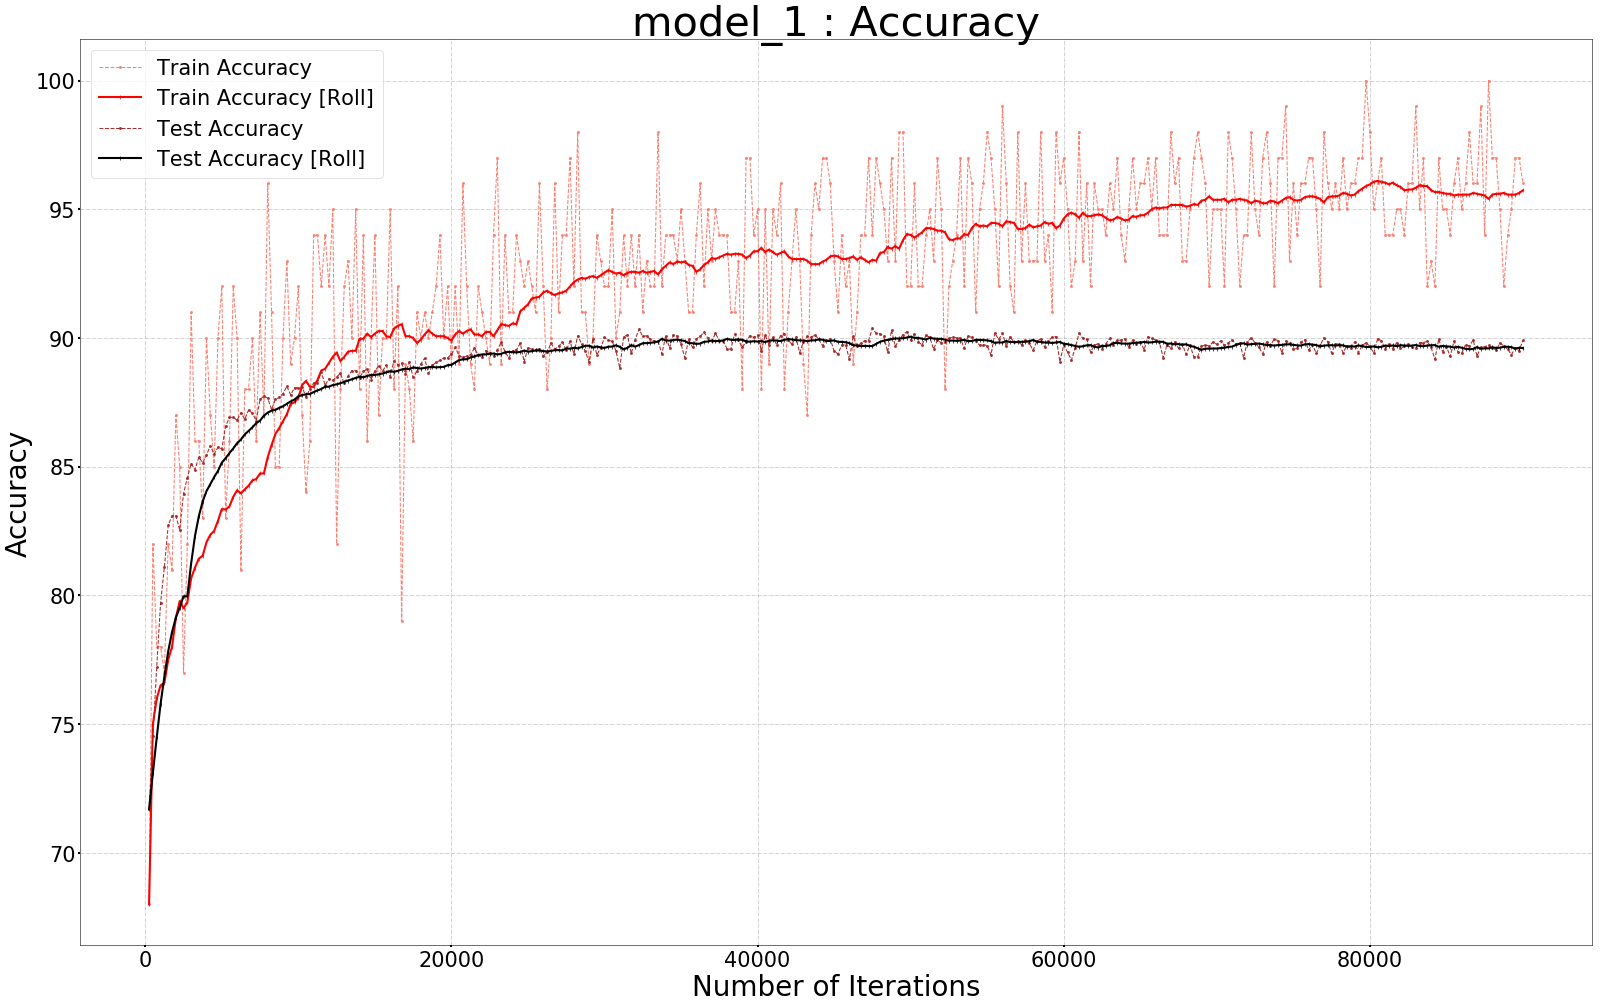

In [59]:
'''PLOTTTING THE ACCURACY GRAPH'''

plt.figure(figsize=[39,24], dpi=50)

plt.plot(iter_list, train_acc_list, '--.', c='salmon', label='Train Accuracy')
plt.plot(iter_list, train_roll_acc_list, '-|r', lw=3, label='Train Accuracy [Roll]')

plt.plot(iter_list, test_acc_list, '--.', c='brown', label='Test Accuracy')
plt.plot(iter_list, test_roll_acc_list, '-|k', lw=3, label='Test Accuracy [Roll]')

plt.title(model_name + ' : Accuracy', size='60')
plt.xlabel('Number of Iterations', size='40')
plt.ylabel('Accuracy', size='40')

plt.grid(True, linestyle='-.',)
plt.tick_params(labelcolor='k', labelsize='30', width=3)

plt.legend(fontsize='30')
plt.show()

#plt.savefig(model_name + ' [1 - accuracy_vs_iterations] [(40,24) - 120dpi].png', dpi=120)

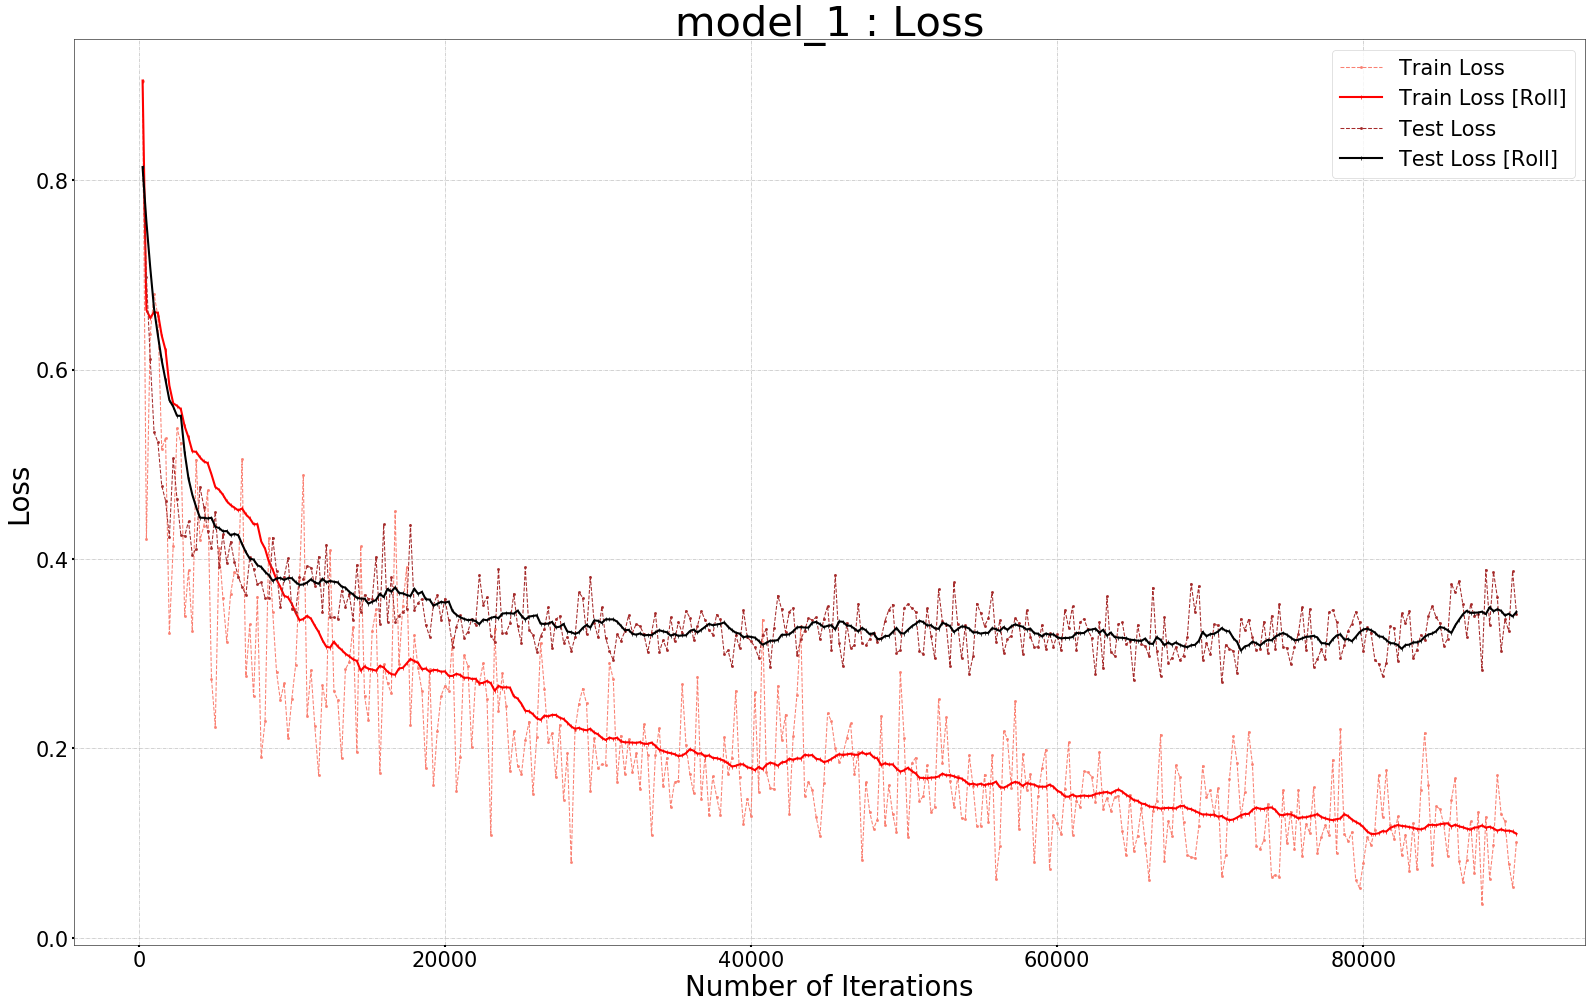

In [60]:
'''PLOTTTING THE LOSS GRAPH'''

plt.figure(figsize=[39,24], dpi=50)

plt.plot(iter_list, train_loss_list, '--.', c='salmon', label='Train Loss')
plt.plot(iter_list, train_roll_loss_list, '-|r', lw=3, label='Train Loss [Roll]')

plt.plot(iter_list, test_loss_list, '--.', c='brown', label='Test Loss')
plt.plot(iter_list, test_roll_loss_list, '-|k', lw=3, label='Test Loss [Roll]')


plt.title(model_name + ' : Loss', size='60')
plt.xlabel('Number of Iterations', size='40')
plt.ylabel('Loss', size='40')

plt.grid(True, linestyle='-.')
plt.tick_params(labelcolor='k', labelsize='30', width=3)

plt.legend(fontsize='30')
plt.show()

#plt.savefig(model_name + ' [1 - loss_vs_iterations] [(40,24) - 120dpi].png', dpi=120)

In [39]:
'''ANALYZING ACCURACY AND LOSS'''

### ACCURACY ANALYSIS
print('Accuracy Analysis : ')
test_max_acc = np.max(test_roll_acc_list)
print('Maximum accuracy on test-set  : {:.2f}'.format(test_max_acc))
print('Iteration at maximum accuracy : {}'.format(iter_list[test_roll_acc_list.index(test_max_acc)]))

### LOSS ANALYSIS
print('\nLoss Analysis : ')
test_min_loss = np.min(test_roll_loss_list)
print('Minimum loss on test-set   : {:.2f}'.format(test_min_loss))
print('Iteration at minimum loss  : {}'.format(iter_list[test_roll_loss_list.index(test_min_loss)]))

Accuracy Analysis : 
Maximum accuracy on test-set  : 90.05
Iteration at maximum accuracy : 50000

Loss Analysis : 
Minimum loss on test-set   : 0.30
Iteration at minimum loss  : 72000


# STORING THE MODEL

In [56]:
'''PICKLING RESULTS'''

iteration_to_save = '90K'
backup_folder = os.path.join('backup_files', model_name)
os.makedirs(backup_folder, exist_ok=True)

### EVALUATION PARAMETERS ###
# Useful in plotting and analysing graphs 
mdict = {}
list_name = ['iter_list', 'train_loss_list', 'train_acc_list', 'test_loss_list', 'test_acc_list']
for i in range(len(list_name)):
    mdict[list_name[i]] = eval(list_name[i])  

fileObject = open(os.path.join(backup_folder,'{} [{} - evalP]'.format(model_name, iteration_to_save)),'wb')
pickle.dump(mdict,fileObject)   
fileObject.close()

### MODEL PARAMETERS ###
# Useful in further training the model
msd = model.state_dict()
fileObject = open(os.path.join(backup_folder,'{} [{} - modelP]'.format(model_name, iteration_to_save)),'wb')
pickle.dump(msd,fileObject)   
fileObject.close()

### STATE-TIME DATA ###
timeState = [time_begin, time_end, str(iterr)]
fileObject = open(os.path.join(backup_folder,'{} [{} - timeState]'.format(model_name, iteration_to_save)),'wb')
pickle.dump(timeState, fileObject)   
fileObject.close()

In [57]:
'''RESTORING PICKLED RESULTS'''

iteration_to_load = '90K'
backup_folder = os.path.join('backup_files', model_name)
os.makedirs(backup_folder, exist_ok=True)

### EVALUATION PARAMETERS ###
fileObject = open(os.path.join(backup_folder,'{} [{} - evalP]'.format(model_name, iteration_to_save)),'rb')
mdictx = pickle.load(fileObject)  

iter_list = mdictx['iter_list']
train_loss_list = mdictx['train_loss_list']
train_acc_list = mdictx['train_acc_list']
test_loss_list = mdictx['test_loss_list']
test_acc_list = mdictx['test_acc_list']

### MODEL PARAMETERS ###
fileObject = open(os.path.join(backup_folder,'{} [{} - modelP]'.format(model_name, iteration_to_save)),'rb')
msd = pickle.load(fileObject) 
model.load_state_dict(state_dict = msd)

### STATE-TIME DATA ###
fileObject = open(os.path.join(backup_folder,'{} [{} - timeState]'.format(model_name, iteration_to_save)),'rb')
timeState = pickle.load(fileObject) 

time_begin = timeState[0]
time_end = timeState[1]
iterr = int(timeState[2])

In [ ]:
'''TRIMMING THE DATA'''
# Useful if checkpoint measurements have been taken for values other than 'inspect_size' = 250.
# 'factor' effectively transforms the data such that 'inspect_size' decreses by a factor of its value.
factor = 5

### Backing up the Data
# iter_list_store = iter_list
# train_loss_list_store = train_loss_list
# train_acc_list_store = train_acc_list
# test_loss_list_store = test_loss_list
# test_acc_list_store = test_acc_list

### Trimming the data
# iter_list = [iter_list[i+factor-1] for i in range(len(iter_list)) if i%factor==0]
# train_loss_list = [train_loss_list[i+factor-1] for i in range(len(train_loss_list)) if i%factor==0]
# train_acc_list = [train_acc_list[i+factor-1] for i in range(len(train_acc_list)) if i%factor==0]
# test_loss_list = [test_loss_list[i+factor-1] for i in range(len(test_loss_list)) if i%factor==0]
# test_acc_list = [test_acc_list[i+factor-1] for i in range(len(test_acc_list)) if i%factor==0]

### Verifying if the trim was succesful 
# print(len(iter_list_store), len(iter_list))
# print(len(train_loss_list_store), len(train_loss_list))
# print(len(train_acc_list_store), len(train_acc_list))
# print(len(test_loss_list_store), len(test_loss_list))
# print(len(test_acc_list_store), len(test_acc_list))

# print(iter_list[:7],'\t', iter_list[-7:])
# print(iter_list_store[:7],'\t', iter_list_store[-7:])

In [42]:
a = 'awdad'
b = 'dsfsdfs'
os.path.join(a,b)

'awdad\\dsfsdfs'